[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [2]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

#### Provide openai API key when prompted
> You'll need to restart the kernel if you run this cell multiple times. Run this manually once.

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

#### Provide langsmith API key when prompted
> You'll need to restart the kernel if you run this cell multiple times. Run this manually once.

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [5]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [6]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")
llm.invoke(messages)

AIMessage(content='In addition to whales, there are several other fascinating ocean mammals you might want to learn about:\n\n1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are social animals that often live in pods.\n\n2. **Porpoises**: Similar to dolphins but typically smaller, porpoises are also highly social and known for their rounded faces.\n\n3. **Seals**: There are several species of seals, including harbor seals and elephant seals. They are known for their agility in the water and often haul out on land to rest.\n\n4. **Sea Lions**: Similar to seals, sea lions are known for their loud barking and can often be seen in larger groups.\n\n5. **Narwhals**: Known as the "unicorn of the sea," narwhals are distinguished by their long, spiral tusk, which is actually an elongated tooth.\n\n6. **Manatees**: Also known as sea cows, manatees are gentle herbivores that inhabit warm coastal waters and rivers.\n\n7. **Dugongs**: Similar to manatees, these marine 

We can run our chat model in a simple graph with `MessagesState`.

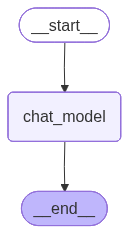

In [7]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals you might want to learn about:

1. **Dolphins** - Known for their intelligence and social behavior. Bottlenose dolphins are the most well-known species.

2. **Seals** - These marine mammals are found in various environments. Common species include harbor seals and elephant seals.

3. **Sea Lions** - Similar to seals but with external ear flaps and a more sociable behavior. California sea lions are a popular species often seen in aquariums.

4. **Manatees** - Often called sea cows, these gentle herbivores inhabit warm coastal waters and rivers.

5. **Walruses** - Recogni

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

#### First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

In [9]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages (id 3 and 4)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages) # filter out messages id 1 and 2
builder.add_node("chat_model", chat_model_node) # add new message generated by the LLM
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
#display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# Message list with a preamble
# Preamble: block of messages that are added to the start of a 
# conversation before the user/AI messages that establish context or instructions for the model.
# E.g: system prompt, persona or role instruction, context injection
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals you might want to learn about:

1. **Dolphins**: Highly intelligent and social creatures, dolphins belong to the family of cetaceans, like whales. The bottlenose dolphin is one of the most well-known species.

2. **Porpoises**: Similar to dolphins but generally smaller, porpoises also have a more rounded snout and differ in social behavior.

3. **Sea Lions**: These marine mammals are known for their external ear flaps and can be quite playful. Sea lions are often found along the coasts.

4. **Seals**: Unlike sea lions, seals lack external ear flap

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.
> "messages[-1:]" returns a list containing only the last message wrapped as a list, instead of only the single object we'd get from "messages[-1]", since llm.invoke() expects a list of messages.

In [11]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
#display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [12]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [13]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals you might want to learn about:

1. **Dolphins**: Highly intelligent and social creatures, dolphins belong to the family of cetaceans, like whales. The bottlenose dolphin is one of the most well-known species.

2. **Porpoises**: Similar to dolphins but generally smaller, porpoises also have a more rounded snout and differ in social behavior.

3. **Sea Lions*

In [14]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})

# Prints the entire state to check it still has ALL the messages
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals you might want to learn about:

1. **Dolphins**: Highly intelligent and social creatures, dolphins belong to the family of cetaceans, like whales. The bottlenose dolphin is one of the most well-known species.

2. **Porpoises**: Similar to dolphins but generally smaller, porpoises also have a more rounded snout and differ in social behavior.

3. **Sea Lions*

#### The state has all of the mesages.

#### But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

### Conclusion
Although the state has all of the messages, only the last message is sent to the model, so there is a token cost optimization.

#### Filtering Messages

In LangGraph, the state can maintain the entire conversation history, but you control how much of that history is passed to the model. For example:

```python
# Only send the last message to the model
llm.invoke(state["messages"][-1:])
```

Here, the state still contains all messages, but the model only sees the most recent one. 
> This pattern is useful when you want to optimize token usage and each response should depend only on the latest user input (e.g., stateless chat or FAQ bots). 

However, if a user’s query depends on earlier parts of the conversation, that context will be missing because only the last message was provided. 

> In those cases, you may choose to pass the last N messages (e.g., state["messages"][-3:]) or the full history (state["messages"][:]). 

This selective filtering gives you a trade-off between **cost efficiency** and **context preservation**, depending on the needs of your application.

##### Keeping the full state is still important:

- Other nodes (e.g. filters, analytics, memory updaters) may rely on the entire history.

- You may want to implement a different node later that uses more of the history.

- LangSmith traces and debugging are clearer when the whole conversation is preserved.


## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

##### This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

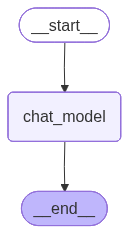

In [15]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100, # TOKEN LIMITATION
            strategy="last", # Keep the last <= n_count tokens of the messages
            token_counter=ChatOpenAI(model="gpt-4o-mini"),
            allow_partial=False, # Whether to split a message if only part of the message can be included. If ``strategy="last"`` then the last partial contents of a message are included.
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
# adding new messages to the message list
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))
messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
 AIMessage(content='In addition to whales, there are several fascinating ocean mammals you might want to learn about:\n\n1. **Dolphins**: Highly intelligent and social creatures, dolphins belong to the family of cetaceans, like whales. The bottlenose dolphin is one of the most well-known species.\n\n2. **Porpoises**: Similar to dolphins but generally smaller, porpoises also have a more rounded snout and differ in social behavior.\n\n3. **Sea Lions**: These marine mammals are known for their external ear flaps and can

In [ ]:
# Example of trimming messages after adding more messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o-mini"),
            allow_partial=False
        )
# In langsmith, we see that the model only received "Tell me where Orcas live!"

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [22]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

In [21]:
# Allowing partial messages
# Example of trimming messages after adding more messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o-mini"),
            allow_partial=True
        )

[AIMessage(content="\n7. **Unique Adaptations**: Narwhals have adaptations for living in cold waters, such as a thick layer of blubber for insulation and a specialized circulatory system that helps them manage their body temperature.\n\nNarwhals are emblematic of the Arctic's unique biodiversity, and their striking appearance often captivates researchers and the public alike.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 417, 'prompt_tokens': 17, 'total_tokens': 434, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CJlx0NVXWHRZmLipdyQpJQMQbGuMW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d9a57e0f-f51f-497f-b6fb-352c6e77b9ee-0', usage_metadata={'input_to

In [23]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100, # TOKEN LIMITATION
            strategy="last", # Keep the last <= n_count tokens of the messages
            token_counter=ChatOpenAI(model="gpt-4o-mini"),
            allow_partial=True, # Whether to split a message if only part of the message can be included. If ``strategy="last"`` then the last partial contents of a message are included.
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

In [ ]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

# In langsmith, we see that the model received the previous partial AI message + "Tell me where Orcas live!"

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r